### Inspiration
- https://public.tableau.com/app/profile/mateusz.karmalski/viz/F1ResultsTracker/Results

In [1]:
%pip install fastf1

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: fastf1 in c:\users\jericho\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (3.1.2)




[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\Jericho\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from matplotlib import pyplot as plt
import fastf1
import fastf1.plotting

In [3]:
session = fastf1.get_session(2023, 'Qatar', 'S')  # Session identifiers: https://theoehrly.github.io/Fast-F1-Pre-Release-Documentation/events.html#sessionidentifier
session.load()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\Jericho\AppData\Local\Temp\fastf1.
	Size: 64.07 MB
core           INFO 	Loading data for Qatar Grand Prix - Sprint [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '4', '63', '44', '55', '16', '23', '14', '1

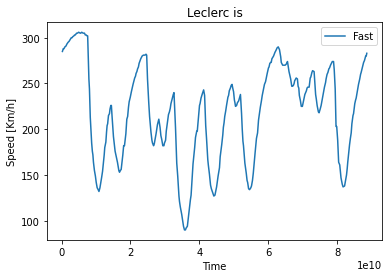

In [4]:
fast_leclerc = session.laps.pick_driver('LEC').pick_fastest()
lec_car_data = fast_leclerc.get_car_data()
t = lec_car_data['Time']
vCar = lec_car_data['Speed']

# The rest is just plotting
fig, ax = plt.subplots()
ax.plot(t, vCar, label='Fast')
ax.set_xlabel('Time')
ax.set_ylabel('Speed [Km/h]')
ax.set_title('Leclerc is')
ax.legend()
plt.show()

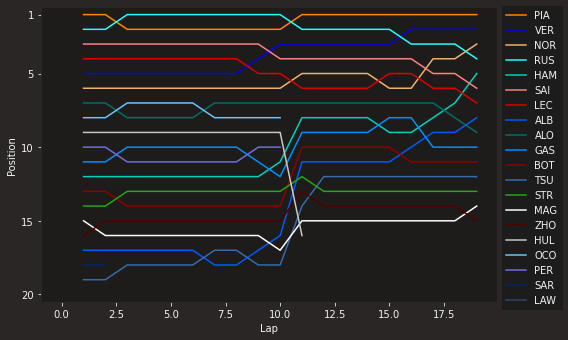

In [5]:
# Create the plot
fastf1.plotting.setup_mpl(misc_mpl_mods=False)
fig, ax = plt.subplots(figsize=(8.0, 4.9))

# For each driver, get their three letter abbreviation (e.g. ‘HAM’) by simply using the value of the first lap, get their color and then plot their position over the number of laps.
for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = fastf1.plotting.driver_color(abb)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, color=color)

# Finalize the plot by setting y-limits that invert the y-axis so that position one is at the top, set custom tick positions and axis labels.
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

# Because this plot is very crowed, add the legend outside the plot area.
ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()


# https://docs.fastf1.dev/examples_gallery/plot_position_changes.html#sphx-glr-examples-gallery-plot-position-changes-py

In [6]:
laps = session.laps

drivers = session.drivers
print(drivers)

drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
print(drivers)

['81', '1', '4', '63', '44', '55', '16', '23', '14', '10', '77', '22', '18', '20', '24', '27', '31', '11', '2', '40']
['PIA', 'VER', 'NOR', 'RUS', 'HAM', 'SAI', 'LEC', 'ALB', 'ALO', 'GAS', 'BOT', 'TSU', 'STR', 'MAG', 'ZHO', 'HUL', 'OCO', 'PER', 'SAR', 'LAW']


We need to find the stint length and compound used for every stint by every driver. We do this by first grouping the laps by the driver, the stint number, and the compound. And then counting the number of laps in each group.

In [7]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

The number in the LapNumber column now stands for the number of observations in that group aka the stint length.

In [8]:
stints = stints.rename(columns={"LapNumber": "StintLength"})
print(stints)

   Driver  Stint Compound  StintLength
0     ALB    1.0   MEDIUM           19
1     ALO    1.0     SOFT           19
2     BOT    1.0   MEDIUM           19
3     GAS    1.0     SOFT           19
4     HAM    1.0   MEDIUM           19
5     HUL    1.0   MEDIUM           11
6     LAW    1.0   MEDIUM            1
7     LEC    1.0     SOFT           19
8     MAG    1.0   MEDIUM           11
9     MAG    2.0     SOFT            8
10    NOR    1.0   MEDIUM           19
11    OCO    1.0     SOFT           11
12    PER    1.0   MEDIUM           11
13    PIA    1.0   MEDIUM           19
14    RUS    1.0     SOFT           19
15    SAI    1.0     SOFT           19
16    SAR    1.0     SOFT            3
17    STR    1.0     SOFT           11
18    STR    2.0     SOFT            8
19    TSU    1.0   MEDIUM           19
20    VER    1.0   MEDIUM           19
21    ZHO    1.0   MEDIUM           11
22    ZHO    2.0     SOFT            8


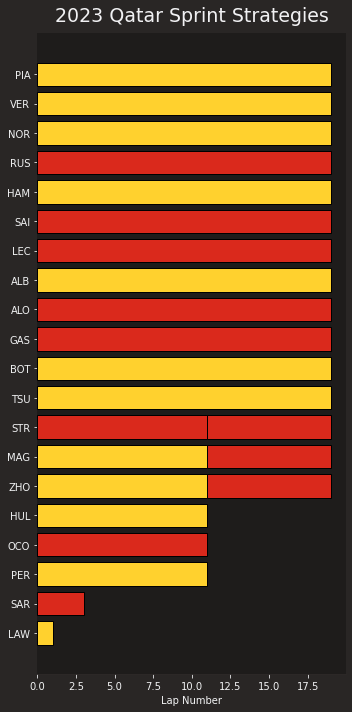

In [9]:
# Now we can plot the strategies for each driver
fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

# Make the plot more readable and intuitive
plt.title("2023 Qatar Sprint Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

# Plot aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


# https://docs.fastf1.dev/examples_gallery/plot_strategy.html#sphx-glr-examples-gallery-plot-strategy-py